# Traitement des données des simulations

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import scipy
from scipy import signal
import sympy as sy
from IPython.display import display
from scipy.io.wavfile import write as wavWrite
import h5py
import ast
import os
import sys
import shutil
sy.init_printing()
import tikzplotlib

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Settings pour les figures matplotlib
mpl.rcParams['figure.dpi'] = 72

#%matplotlib nbagg

FIGSIZE  = (10,5)
FONTSIZE = 30
TICK_FONTSIZE = 24
LEGEND_FONTSIZE = 22

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.rc('text', usetex=True)
LATEX_FIG_PATH = "../01_FIGS/"
FIGS_PATH      = "02_figs/"
PPTY_XVBAR = {'c':  'r', 
              'linestyle':'-.', 
              'linewidth':2,
             }
PPTY_LEG = { 'fontsize' : 16,
             'loc'      : 'upper left',
           }

In [3]:
fmt = lambda s: r'%s_{%s}' % (s.split('_', 1)[0], s.split('_', 1)[1].replace('_', ''))

def export2tikzpdf(path, name):
    """ Exporte la figure courante dans un nouveau dossier,
    en y ajoutant un numéro unique, ordre croissant
    @args: path: chemin vers le dossier d'export
    @args: name: nom du dossier 
    """
    # Liste des dossier dans le path    
    list_dir = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        list_dir.extend(dirnames)
        break
        
        
    # Dans le cas où la liste de dossier est vide
    if not list_dir:
        list_dir.append(str(0))
    
    # Nombre le plus grand?
    for i in range(len(list_dir)):
        list_dir[i] = int(list_dir[i][0:2])
        
    # rajoute un zéro au debut si < 10 (formattage)
    new_fig_number = str(max(list_dir) + 1).zfill(2)

    full_path_new_dir = os.path.join(path, 
                                     str(new_fig_number) + '_' + name)
    
    # Création du nouveau dossier
    os.mkdir(full_path_new_dir)
    
    # Copie des fichiers de makefile + conteneur latex
    src_files = ['fig_main.tex', 'makefile']
    dst_files = ['','']
    for i in range(len(src_files)):
        dst_files[i] = os.path.join(full_path_new_dir, src_files[i])
        src_files[i] = os.path.join(path, src_files[i])
        shutil.copyfile(src_files[i], dst_files[i])

    # generation du fichier tikz
    tikz_file_path = os.path.join(full_path_new_dir,"fig.tex")
    tikzplotlib.save(tikz_file_path)
    
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()

### Chargement des données

In [11]:
#%% Loading dataset
%store -r filename 
print(filename)
filename = '03_data/simu.03_11.16_46.h5'

fid = h5py.File(filename, 'r')
fid.flush()

metadata = fid["metadata"]
data     = fid["data_simu"]
model    = fid["model"]

date_now = metadata["date_now"][:]
config = ast.literal_eval(str(metadata["config"][0]))
print(*date_now)

03_data/simu.03_11.18_14.h5
3 11 16 46


In [14]:
SAVE_FIG = True
if SAVE_FIG:
    FOLDER_PATH = FIGS_PATH + "simu_{0}_{1}.{2}_{3}".format(*(str(val).zfill(2) for val in date_now))
    os.mkdir(FOLDER_PATH)

In [6]:
t = data["t"][:]
tmax = max(t)

indt = (t <= tmax) * (t >= 0.)

N_ports, Nx, NW = model["Nu"][0], model["Nx"][0], model["Nw"][0]

In [7]:
#xbar = [t[300],]
xbar = []

In [8]:
config

{'fs': 100000.0,
 'path': '/home/victorw/ownCloud/IRCAM/03_DOCS/21_simulations_FA2020/02_python/03_data',
 'lang': 'c++',
 'cmake': 'cmake',
 'grad': 'discret',
 'maxit': 20,
 'pbar': False,
 'split': False,
 'timer': True,
 'epsdg': 5.477420592293901e-07,
 'eps': 2.220446049250313e-16}

In [9]:
volume_refs = [model["VT_subs"]["V_01"][()], model["VT_subs"]["V_02"][()]]
rho_refs    = [model["VT_subs"]["rho_0"][()], model["VT_subs"]["rho_0"][()]]

In [13]:
model["VT_subs"]["Z_ray"][()]

--------------
## Entrées

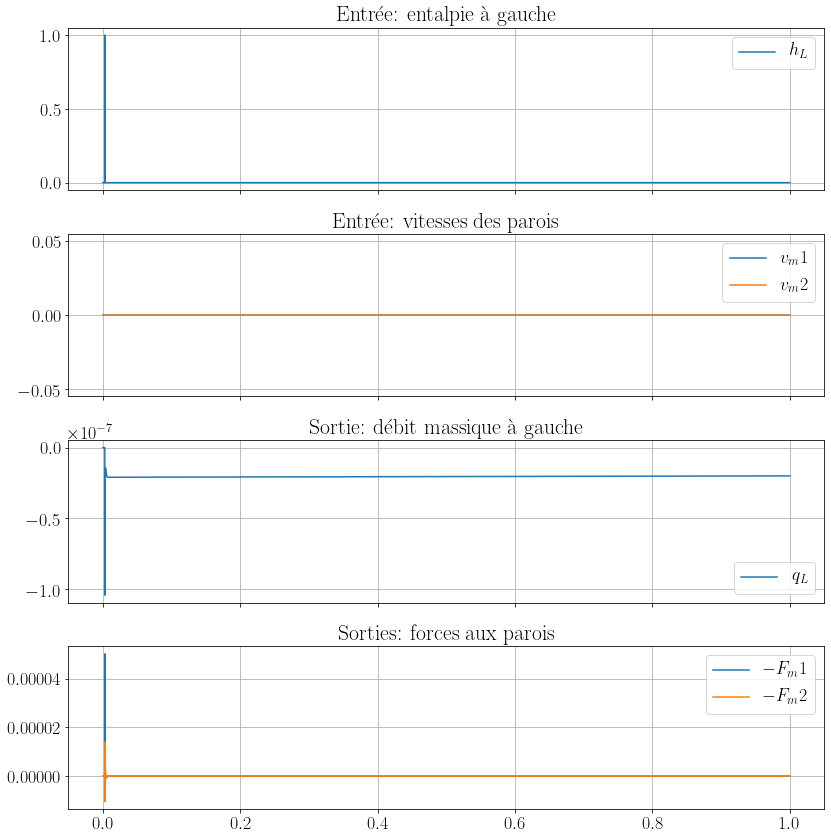

In [10]:
#%matplotlib nbagg
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

## Entrées
ax = axs[0]
label = r'$%s$' % (model["u_label"][0])
ax.plot(t[indt], data["u"][indt,0], label=label)
ax.set_title('Entrée: entalpie à gauche')
for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

# Vitesses
ax = axs[1]
for i in range(1,N_ports):
    label = r'$%s$' % (model["u_label"][i])
    ax.plot(t[indt], data["u"][indt,i], label=label)
ax.set_title('Entrée: vitesses des parois')

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

## Sorties: Forces

ax = axs[2]
label = r'$%s$' % (model["y_label"][0])
ax.plot(t[indt], data["y"][indt,0], label=label)
ax.set_title('Sortie: débit massique à gauche')

ax = axs[3]
for i in range(1, N_ports):
    label = r'$%s$' % (model["y_label"][i])
    ax.plot(t[indt], data["y"][indt,i], label=label)
ax.set_title('Sorties: forces aux parois')

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)


for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

for ax in axs.ravel():
    ax.legend(frameon=True)
    ax.grid()

plt.tight_layout()
for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
    
if SAVE_FIG:
    title = "input_output"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

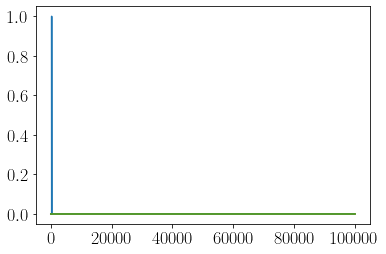

In [11]:
plt.plot(data["u"][indt,:])

----------
## Bilan de puissance et ports

In [21]:
# Calcule du bilan de puissance
N_diss = len(model["w_label"][:])
Pdiss = np.prod([data["w"][:,0],data["z"][:,0]], axis=0)
for i in range(1, N_diss):
    prod = np.prod([data["w"][:,i],data["z"][:,i]], axis=0)
    Pdiss = np.add(Pdiss, prod)

Pext = np.prod([data["u"][:,0],data["y"][:,0]], axis=0)
for i in range(1, N_ports):
    prod = np.prod([data["u"][:,i],data["y"][:,i]], axis=0)
    Pext = np.add(Pext, prod)

dEdt = np.prod([data["dxH"][:,0],data["dtx"][:,0]], axis=0)
for i in range(1,Nx):
    prod = np.prod([data["dxH"][:,i],data["dtx"][:,i]], axis=0)
    dEdt = np.add(dEdt, prod)

<IPython.core.display.Javascript object>


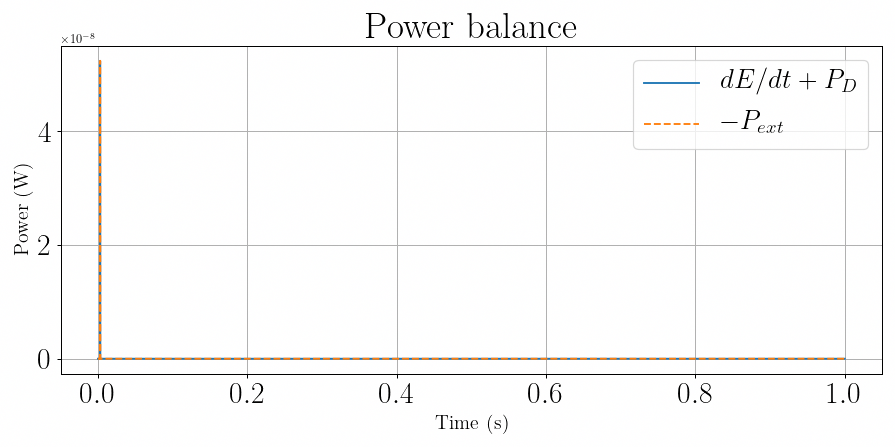

In [22]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()

# ---- Power balance --- #
ax.plot(t[indt], (Pdiss + dEdt)[indt])
ax.plot(t[indt], (-Pext)[indt], '--')
ax.set_title(r'Power balance', fontsize=FONTSIZE)
ax.grid()

ax.legend([r'$dE/dt + P_D$', '$-P_{ext}$'], fontsize=LEGEND_FONTSIZE)
ax.set_ylabel('Power (W)', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
ax.tick_params(axis='both', which='minor', labelsize=TICK_FONTSIZE)

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
plt.tight_layout()


if SAVE_FIG:
    title = "power_balance"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

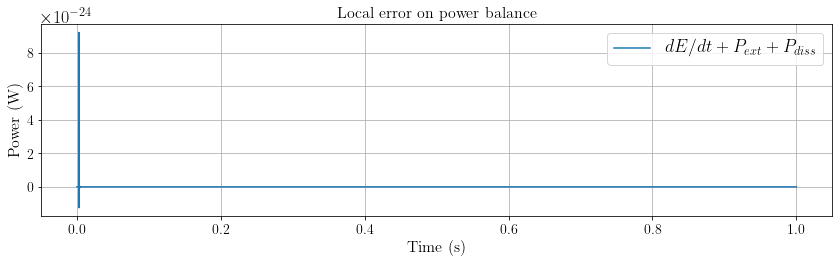

In [14]:
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

# ---- Power balance --- #
ax.plot(t[indt], (dEdt+Pext+Pdiss)[indt])
ax.set_title(r'Local error on power balance', fontsize=16)
ax.grid()

ax.legend([r'$dE/dt+P_{ext}+P_{diss}$'])
ax.set_ylabel('Power (W)', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
plt.tight_layout()

if SAVE_FIG:
    title = "error_on_power_balance"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

--------------
## Vue d'ensemble

fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True)


for ind, var in enumerate(model['x_label'][:]):
    label = fmt(str(var))
    ydata = data["x"][indt, ind]
    # Variables en X_L X_R etc...
    if str(var).startswith('X_'):
        # Variables X_n
        ax = axs[0, 0]
    # Piy
    elif str(var).startswith('Pi_y_'):
        ax = axs[0, 1]
        label = r'$\%s$' % label.replace('$', '')
    elif str(var).startswith('V_'):
        ax = axs[0, 2]
    elif str(var).startswith('rho_'):
        ax = axs[1, 2]
        ydata = ydata
        label = r'$\%s$' % label.replace('$', '')
    elif str(var).startswith('x_k'):
        ax = axs[1, 1]
    ax.plot(t[indt], ydata, marker='.', ms=.2, label=label)
    for bar in xbar:
        ax.axvline(x=bar, **PPTY_XVBAR)
        
##########
for ind, var in enumerate(model['y_label'][0:1], start= N_ports - model["N_tube"][0]):
    label = fmt(str(var))
    label = r'$%s$' % label.replace('$', '')
    y_data = data["y"][indt, ind]
    axs[0, 3].plot(t[indt], y_data, marker='.', ms=.2, label = label)
    for bar in xbar:
        axs[0,3].axvline(x=bar, **PPTY_XVBAR)
        
##########
for ind, var in enumerate(model['u_label']):
    label = fmt(str(var))
    ydata = data["u"][indt, ind]
    if str(var).startswith('h_'):
        # Variables h_n
        ax = axs[1, 0]
    elif str(var).startswith('v_m'):
        ax = axs[1, 3]
    ax.plot(t[indt], ydata, marker='.', ms=.2, label=label)
    for bar in xbar:
        ax.axvline(x=bar, **PPTY_XVBAR)

for ax in axs.ravel():
    ax.legend(frameon=True)
    ax.grid()
fig.tight_layout()

if SAVE_FIG:
    title = "preview_var"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path  + '.png', format='png', dpi=300)
    plt.savefig(tmp_path  + '.pdf', format='pdf')

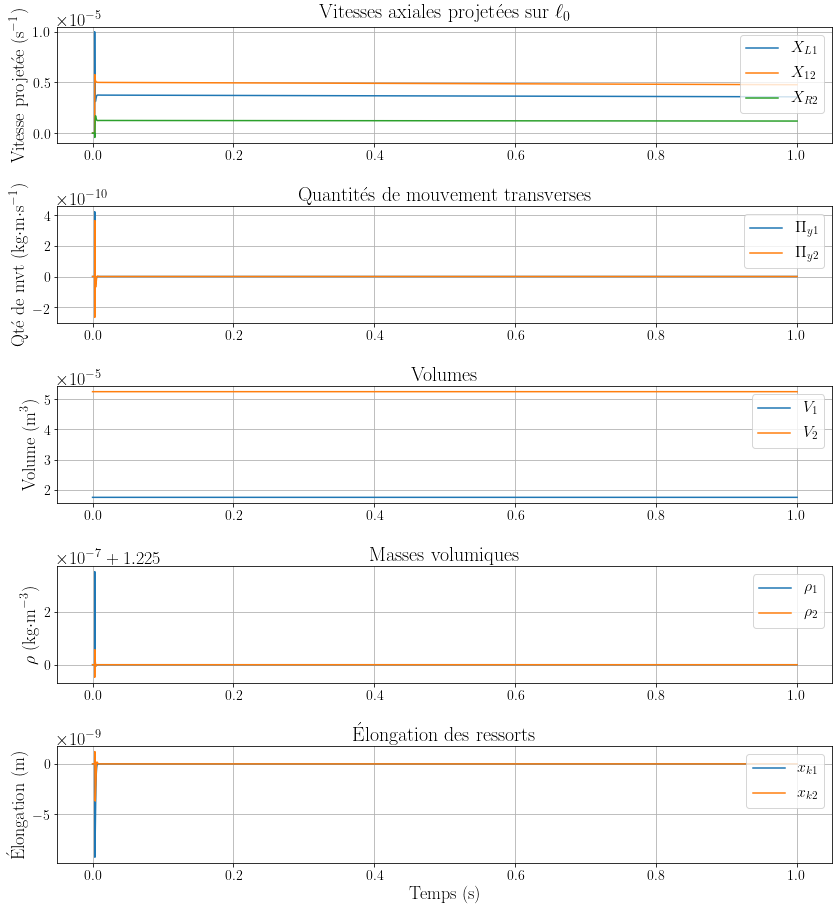

In [15]:
#%matplotlib nbagg
fig, axs = plt.subplots(5, 1, figsize=(12, 13))
plt_dat = "x"

## X_L, X_R, X_1_2
ax = axs[0]
ax.set_title(r"Vitesses axiales projetées sur $\ell_0$", fontsize=20)
ax.set_ylabel(r'Vitesse projetée (s$^{-1}$)')

for i in range(3):
    label = r'$%s$' % (fmt(model[plt_dat + "_label"][i]))
    ax.plot(t[indt], data[plt_dat][indt,i], label=label)
    
## Piy
ax = axs[1]
ax.set_title("Quantités de mouvement transverses", 
             fontsize=20)
ax.set_ylabel('Qté de mvt (kg$\cdot$m$\cdot$s$^{-1}$)')
for i in range(3,5):
    label = r'$\%s$' % (fmt(model[plt_dat + "_label"][i]))
    ax.plot(t[indt], data[plt_dat][indt,i], label=label)

## V
ax = axs[2]
ax.set_title("Volumes", fontsize=20)
ax.set_ylabel('Volume (m$^3$)')
for i in range(5,7):
    label = r'$%s$' % (fmt(model[plt_dat + "_label"][i]))
    ax.plot(t[indt], data[plt_dat][indt,i]+ volume_refs[i-5], label=label)
    
## rho
ax = axs[3]
ax.set_title("Masses volumiques", fontsize=20)
ax.set_ylabel(r'$\rho$ (kg$\cdot$m$^{-3}$)')
for i in range(7,9):
    label = r'$\%s$' % (fmt(model[plt_dat + "_label"][i]))
    ax.plot(t[indt], data[plt_dat][indt,i] + rho_refs[i-7], label=label)
    
## xk
ax = axs[4]
ax.set_title("Élongation des ressorts", 
             fontsize=20)
ax.set_ylabel('Élongation (m)')
ax.set_xlabel('Temps (s)')
for i in range(9,11):
    label = r'$%s$' % (fmt(model[plt_dat + "_label"][i]))
    ax.plot(t[indt], data[plt_dat][indt,i], label=label)


for ax in axs.ravel():
    ax.legend(frameon=True, fontsize=16, loc='upper right')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.tick_params(labelsize=14)
    ax.grid()

    
plt.tight_layout()


if SAVE_FIG:
    title = "x_all"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', dpi=300, format='pdf')

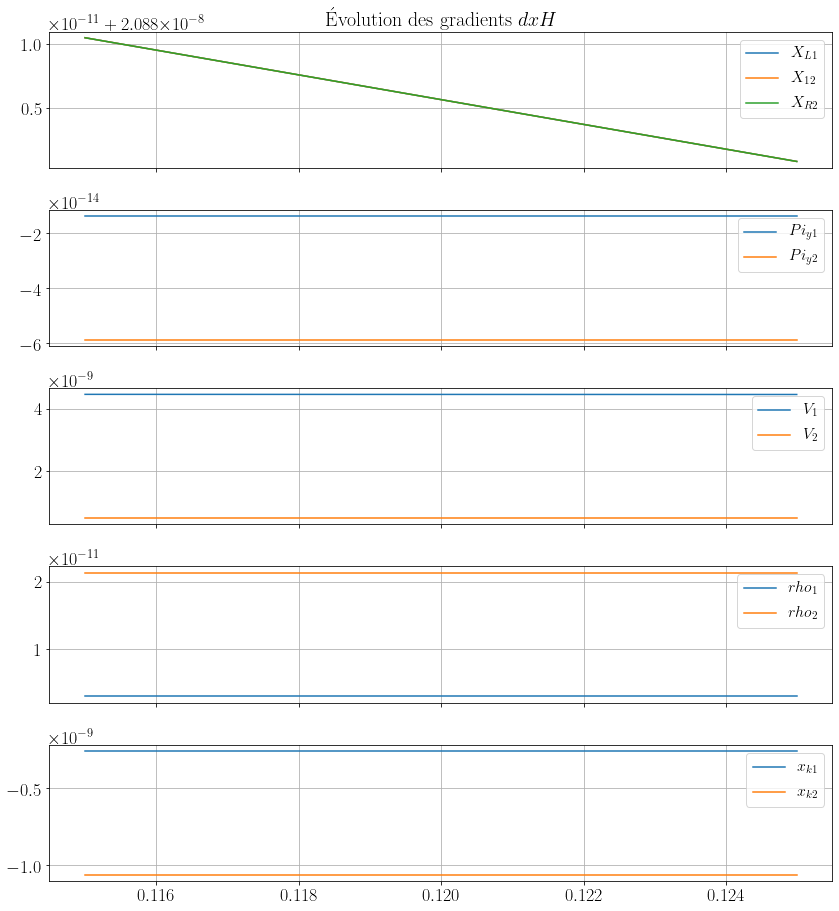

In [16]:
#%matplotlib nbagg
fig, axs = plt.subplots(5, 1, figsize=(12, 13), sharex=True)
indtx = (t>=0.115)*(t<0.125)
plt_dat = "dxH"
## X_L, X_R, X_1_2
ax = axs[0]

for i in range(3):
    label = r'$%s$' % (fmt(model["x_label"][i]))
    ax.plot(t[indtx], data[plt_dat][indtx,i], label=label)
ax.set_title(r"Évolution des gradients $dxH$", fontsize=20)
## Piy
ax = axs[1]
for i in range(3,5):
    label = r'$%s$' % (fmt(model["x_label"][i]))
    ax.plot(t[indtx], data[plt_dat][indtx,i], label=label)

## V
ax = axs[2]
for i in range(5,7):
    label = r'$%s$' % (fmt(model["x_label"][i]))
    ax.plot(t[indtx], data[plt_dat][indtx,i], label=label)
    
## rho
ax = axs[3]
for i in range(7,9):
    label = r'$%s$' % (fmt(model["x_label"][i]))
    ax.plot(t[indtx], data[plt_dat][indtx,i], label=label)
    
## xk
ax = axs[4]
for i in range(9,11):
    label = r'$%s$' % (fmt(model["x_label"][i]))
    ax.plot(t[indtx], data[plt_dat][indtx,i], label=label)
    


for ax in axs.ravel():
    ax.legend(frameon=True, fontsize=16)
    ax.grid()

plt.tight_layout()


if SAVE_FIG:
    title = "dxH_all"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', dpi=300, format='pdf')

In [17]:
print(model["y_label"][:])
print(model["w_label"][:])

['q_L' '-F_m1' '-F_m2']
['v_k1' 'v_k2' 'q']


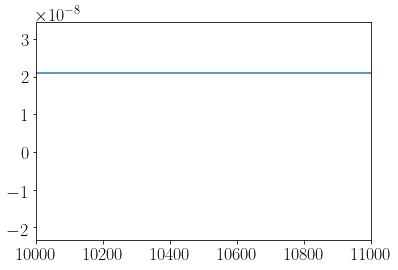

In [18]:
plt.plot(data['w'][:,2])
plt.xlim([10000,11000])

In [19]:
model['x_label'][:]

array(['X_L_1', 'X_12', 'X_R_2', 'Pi_y_1', 'Pi_y_2', 'V_1', 'V_2',
       'rho_1', 'rho_2', 'x_k1', 'x_k2'], dtype=object)

---
## Fonction de transfert débit glottique vers débit aux lèvres

<IPython.core.display.Javascript object>


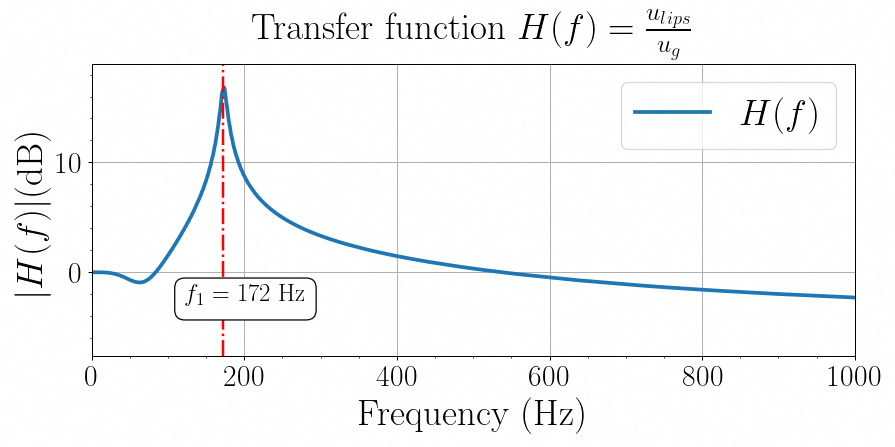

In [19]:
%matplotlib nbagg
q_glotte  = np.divide(data['dxH'][:,0], data['x'][:,7]+rho_refs[0])
q_levres  = np.divide(data['w'][:,2], data['x'][:,8]+rho_refs[0])

sos = signal.butter(200, 10, 'hp', fs=config['fs'], output='sos')
#q_glotte = signal.sosfilt(sos, q_glotte)
#q_levres = signal.sosfilt(sos, q_levres)

len_sig   = len(q_glotte)
fs        = config["fs"]

freq_max  = fs/2
Nfft      = int(next_power_of_2(len_sig))
freq_vec  = np.linspace(-fs/2, fs/2, Nfft) 
indf      = (freq_vec > 0) * (freq_vec < freq_max)
win       = scipy.signal.get_window('hann', len_sig)
#win       = signal.kaiser(len_sig, beta=14)

fft_qout = np.fft.fft(q_levres*win, Nfft)
fft_qin = np.fft.fft(q_glotte*win, Nfft)
fft_H_shift = np.fft.fftshift(np.divide(fft_qout, fft_qin))

############
## FIGURE ##
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()



plt.plot(freq_vec[indf], 10*np.log10(np.abs(fft_H_shift[indf])), linewidth=3)
#plt.loglog(freq_vec[indf], np.abs(fft_H_shift[indf]))
plt.xlabel('Frequency (Hz)', fontsize=FONTSIZE)
plt.ylabel('$|H(f)|$(dB)', fontsize=FONTSIZE)



plt.xlim([0, 1000])
plt.title(r'Transfer function $H(f)=\frac{u_{lips}}{u_{g}}$', fontsize=FONTSIZE)
plt.grid()

plt.legend([r'$H(f)$'],
           fontsize=FONTSIZE, loc='upper right')


freqs = [172]
i = 0
for freq in freqs:
    i = i+1
    ax.axvline(x=freq, **PPTY_XVBAR)
    ann = plt.annotate(r"$f_{0} = {1}$ Hz".format(i,freq), 
                       (freq-50, -3),
                       bbox=dict(boxstyle='Round', fc='white', ec='k', pad=0.4),
                       fontsize=20)

    
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.minorticks_on()


plt.tight_layout()
SAVE_FIG=True
if SAVE_FIG:
    title = "fonction_transfert_uL_vers_uR"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

In [21]:
print(model["u_label"][:])
print(model["y_label"][:])
print(model["w_label"][:])

['h_L' 'v_m1' 'v_m2']
['q_L' '-F_m1' '-F_m2']
['v_k1' 'v_k2' 'q']


<IPython.core.display.Javascript object>


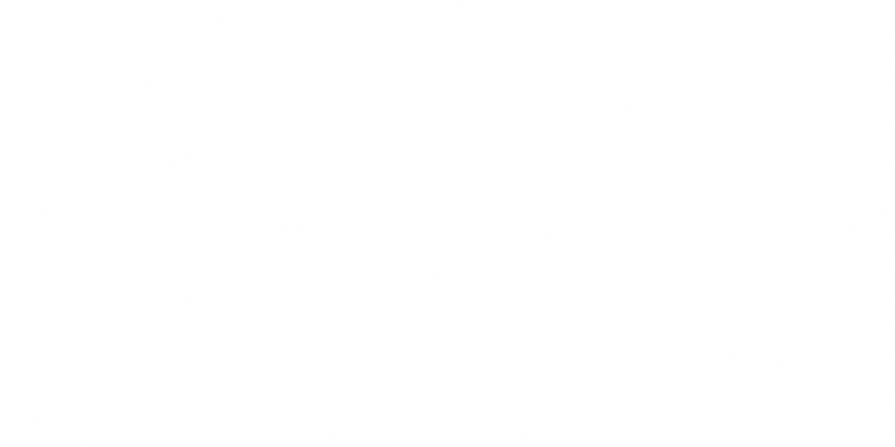

<IPython.core.display.Javascript object>


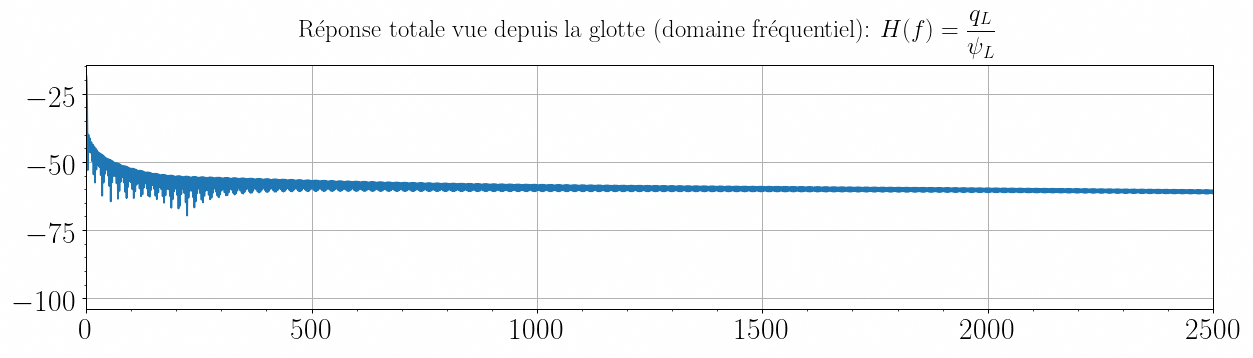

In [22]:
#%matplotlib nbagg
sig_in    = data['u'][:,0]
sig_out   = data['y'][:,0]
len_sig   = len(sig_in)
fs        = config["fs"]

freq_max  = fs/2
Nfft      = int(next_power_of_2(len_sig))
freq_vec  = np.linspace(-fs/2, fs/2, Nfft) 
indf      = (freq_vec > 0) * (freq_vec < freq_max)
win       = scipy.signal.get_window('hamming', len_sig)

fft_in = np.fft.fft(sig_in*win, Nfft)
fft_out = np.fft.fft(sig_out*win, Nfft)
fft_H_shift = np.fft.fftshift(np.divide(fft_out, fft_in))

plt.figure(figsize=FIGSIZE)
plt.figure(figsize=(14,4))
plt.plot(freq_vec[indf], 10*np.log10(np.abs(fft_H_shift[indf])))

plt.xlim([0, 2500])
plt.title(r'Réponse totale vue depuis la glotte (domaine fréquentiel): $ \displaystyle H(f)=\frac{q_{L}}{\psi_{L}}$'
          , fontsize=20)

ax = plt.gca()
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.minorticks_on()

plt.grid()
plt.tight_layout()
if SAVE_FIG:
    title = "fonction_transfert_vue_depuis_la_glotte"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')
    

<IPython.core.display.Javascript object>


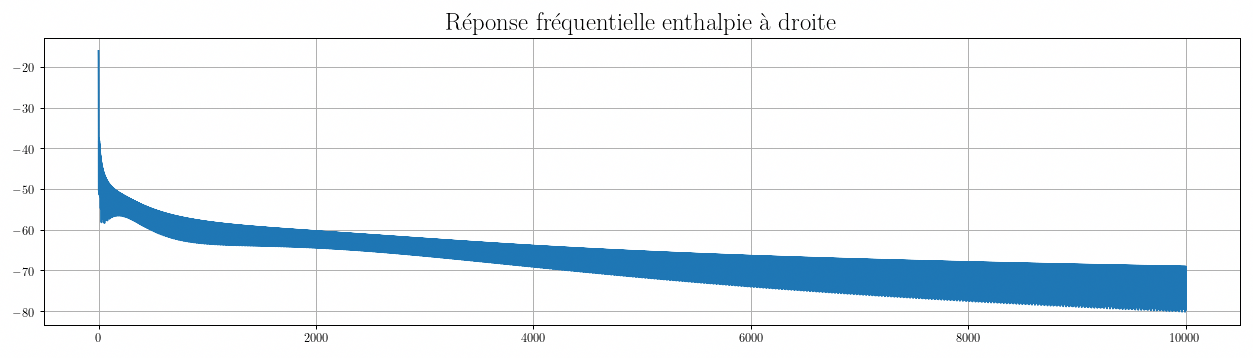

In [23]:
sig_out   = data['z'][:,2]
len_sig   = len(sig_out)
fs        = config["fs"]

freq_max  = 10000
Nfft      = int(next_power_of_2(len_sig)*2)
freq_vec  = np.linspace(-fs/2, fs/2, Nfft) 
indf      = (freq_vec > 0) * (freq_vec < freq_max)
win       = scipy.signal.get_window('hamming', len_sig)

fft_out = np.fft.fftshift(np.fft.fft(sig_out*win, Nfft))

plt.figure(figsize=(14,4))
plt.plot(freq_vec[indf], 10*np.log10(np.abs(fft_out[indf])))
#plt.plot(freq_vec[indf], np.abs(fft_out[indf]))

#plt.xlim([0, 3000])
#plt.ylim([-60,-50])
ax = plt.gca()
plt.title(r'Réponse fréquentielle enthalpie à droite'
          , fontsize=20)

plt.grid()
plt.tight_layout()

if SAVE_FIG:
    title = "repFreq_enthalpie_levres"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

In [24]:
model["x_label"][:]

array(['X_L_1', 'X_12', 'X_R_2', 'Pi_y_1', 'Pi_y_2', 'V_1', 'V_2',
       'rho_1', 'rho_2', 'x_k1', 'x_k2'], dtype=object)

<IPython.core.display.Javascript object>


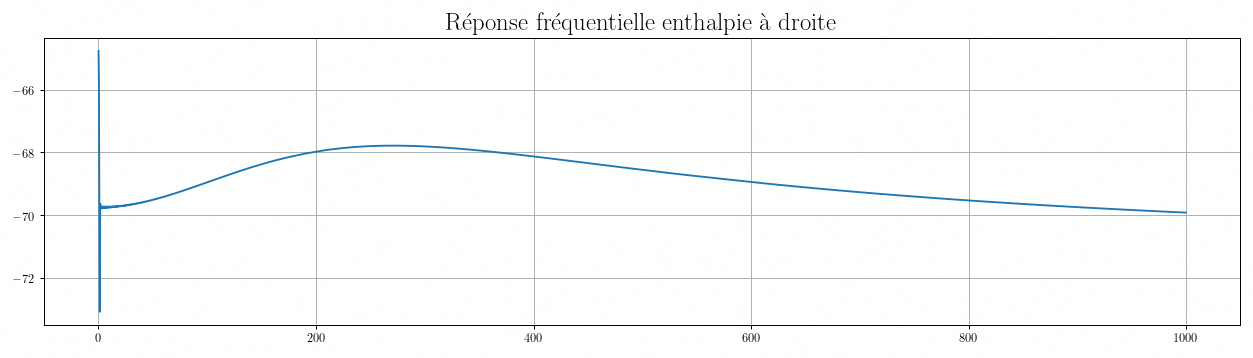

In [37]:
sig_out   = data['x'][:,-3]
len_sig   = len(sig_out)
fs        = config["fs"]

freq_max  = 1000
Nfft      = int(next_power_of_2(len_sig)*2)
freq_vec  = np.linspace(-fs/2, fs/2, Nfft) 
indf      = (freq_vec > 0) * (freq_vec < freq_max)
win       = scipy.signal.get_window('hamming', len_sig)

fft_out = np.fft.fftshift(np.fft.fft(sig_out*win, Nfft))

plt.figure(figsize=(14,4))
plt.plot(freq_vec[indf], 10*np.log10(np.abs(fft_out[indf])))
#plt.plot(freq_vec[indf], np.abs(fft_out[indf]))

#plt.xlim([0, 3000])
#plt.ylim([-60,-50])
ax = plt.gca()
plt.title(r'Réponse fréquentielle enthalpie à droite'
          , fontsize=20)

plt.grid()
plt.tight_layout()

if SAVE_FIG:
    title = "ressort_t1_repFreq"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

<IPython.core.display.Javascript object>


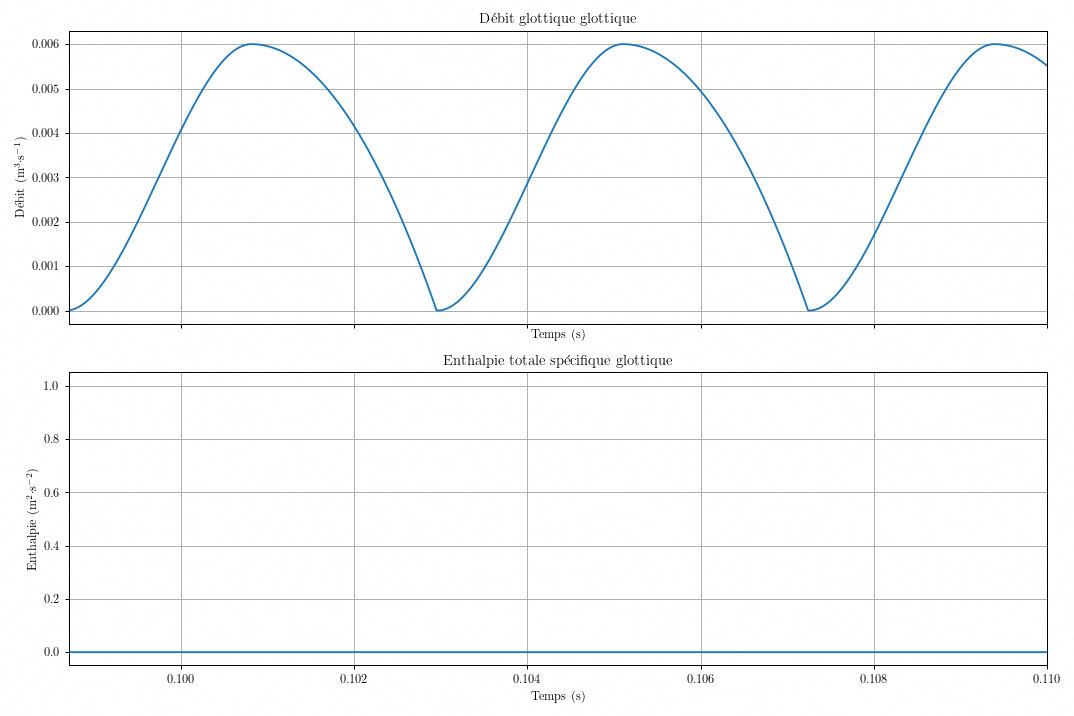

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Débit
ax = axs[0]
Ug = data['Ug'][indt]
Nit = len(Ug)
Ug[int(Nit*0.95)::] = Ug[0:int(Nit*0.05)] = 0
ax.plot(t[indt], Ug)

ax.set_xlabel('Temps (s)')
ax.set_ylabel(r'Débit (m$^3\cdot$s$^{-1}$)')
ax.set_title('Débit glottique glottique')
ax.grid()

# Enthalpie
ax = axs[1]

ax.plot(t[indt], data['u'][indt,0])

ax.set_xlabel('Temps (s)')
ax.set_ylabel(r'Enthalpie (m$^2\cdot$s$^{-2}$)')
ax.set_title('Enthalpie totale spécifique glottique')
ax.grid()

plt.xlim([0.0987, 0.11])
plt.tight_layout()

if SAVE_FIG:
    title = "repTemp_Ug_psiG"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')